In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets

In [2]:
transform = transforms.Compose([transforms.Resize((28, 28)), # to resize the image into 28 * 28 resolution
                                transforms.ToTensor(), # to convert into tensor and also scale between 0 to 1
                                transforms.Normalize((0.5,), (0.5,)) # this normalizes the pixel values by setting mean, std = 0.5.
                                ])

training_dataset = datasets.MNIST(root='./data', train = True, download = True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train = False, download = True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle= True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle= True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images[0].shape)



torch.Size([1, 28, 28])


Since the shape of the image is not suitable for out model and plotting purposes, we wil reshape it and also convert it to 3 channel one.

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # a note on the detach function below
    image = image.transpose(1,2,0) # swaps the places of the channels, the first would be moved to last, giving is (28, 28, 1)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
    image = image.clip(0, 1) # forcibly squashes the value to range between 0 and 1
    return image

**tensor.detach()** creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

The wrapper with **torch.no_grad()** temporarily set all the ***requires_grad*** flag to false. ***torch.no_grad*** says that no operation should build the graph.

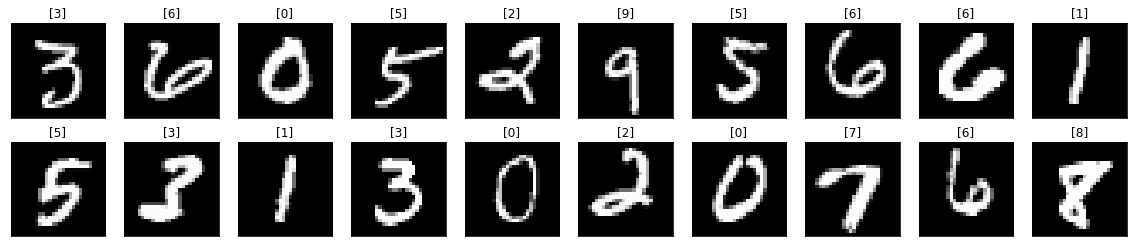

In [5]:
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [6]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0
    running_corrects = 0 
    val_running_loss = 0
    val_running_corrects = 0

    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('Epoch: ', (e+1))
        print('Training Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('Validation Loss: {:4f}, Validation Accuracy'.format(val_epoch_loss, val_epoch_acc.item()))

Epoch:  1
Training Loss: 0.3818, Accuracy: 89.4383
Validation Loss: 0.326072, Validation Accuracy
Epoch:  2
Training Loss: 0.3186, Accuracy: 90.7900
Validation Loss: 0.290420, Validation Accuracy
Epoch:  3
Training Loss: 0.2842, Accuracy: 91.7250
Validation Loss: 0.261892, Validation Accuracy
Epoch:  4
Training Loss: 0.2581, Accuracy: 92.6083
Validation Loss: 0.241598, Validation Accuracy
Epoch:  5
Training Loss: 0.2354, Accuracy: 93.2000
Validation Loss: 0.219877, Validation Accuracy
Epoch:  6
Training Loss: 0.2161, Accuracy: 93.7633
Validation Loss: 0.203167, Validation Accuracy
Epoch:  7
Training Loss: 0.1999, Accuracy: 94.3233
Validation Loss: 0.195998, Validation Accuracy
Epoch:  8
Training Loss: 0.1858, Accuracy: 94.6333
Validation Loss: 0.177998, Validation Accuracy
Epoch:  9
Training Loss: 0.1730, Accuracy: 95.0233
Validation Loss: 0.174530, Validation Accuracy
Epoch:  10
Training Loss: 0.1620, Accuracy: 95.3550
Validation Loss: 0.163868, Validation Accuracy
Epoch:  11
Training

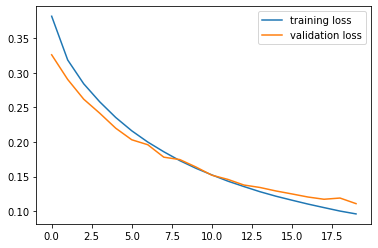

In [11]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()
plt.show()

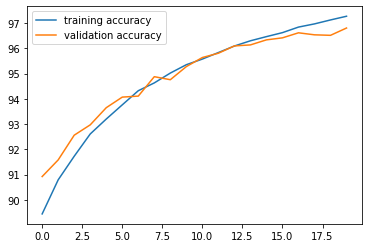

In [12]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()
plt.show()

We can now try with a random image from the internet to validate out model.

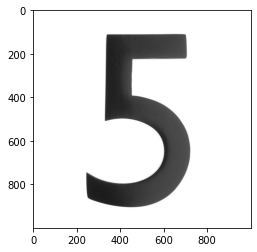

In [28]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);

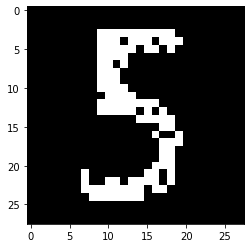

In [29]:
# We have to transform out image so be similar to the ones we have in the MNIST training set.
img = PIL.ImageOps.invert(img) # inverting the background and foreground
img = img.convert('1') # converts the image into binarized like b/w image
img = transform(img)
plt.imshow(im_convert(img))

In [31]:
# feeding it to the model and getting the output
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


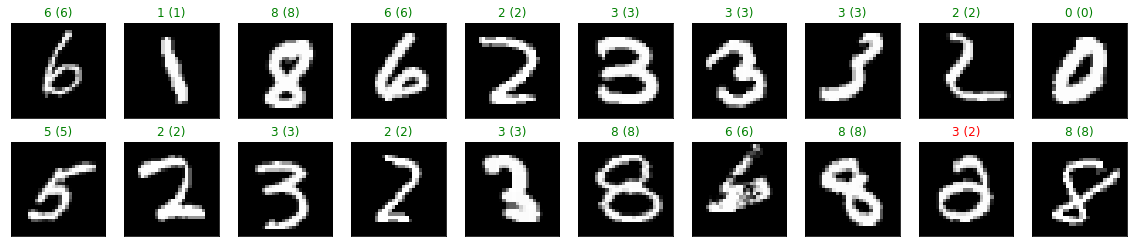

In [34]:
detailer = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (20, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx] == labels[idx] else 'red'))